### Imports

In [227]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

### Create FC NN

In [228]:
class NN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, 50)
        self.fc2 = nn.Linear(50, num_classes)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Set Device

In [229]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Hyperparameters

In [230]:
input_size = 28 * 28
num_classes = 10
learning_rate = 0.001
batch_size = 64
num_epochs = 60

### Load Data

In [231]:
train_dataset = datasets.MNIST(root='datasets/', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = datasets.MNIST(root='datasets/', train=False, transform=transforms.ToTensor(), download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

### Initialize Network

In [232]:
model = NN(input_size=input_size, num_classes=num_classes).to(device)

### Loss and Optimizer

In [233]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### Train NN

In [234]:
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.reshape(data.shape[0], -1)
        
        # Forwardprop
        scores = model(data)
        loss = criterion(scores, targets)
        
        # Backwardprop
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient Descent - Adam Optimization
        optimizer.step()

### Check accuracy on train & test set

In [235]:
def check_accuracy(loader, model):
    if loader.dataset.train:
        print("Checking accuracy on training data")
    else:
        print("Checking accuracy on test data")
    
    num_correct = 0
    num_samples = 0
    model.eval()
    data = []
    pred = []
    true_vals = []
    
    with torch.no_grad(): ## when check accuracy, no need to check gradients
        for x, y in loader:
            true_vals.append(y)
            data.append(x.squeeze(1))
            x = x.to(device=device)
            y = y.to(device=device)
            x = x.reshape(x.shape[0], -1)
            
            scores = model(x) # 64 x 10 dim
            _, predictions = scores.max(1) # axis = 1
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0) # 64
            pred.append(predictions)
        
        print(f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}")
    
    model.train()
    
    return data, pred, true_vals

In [236]:
check_accuracy(train_loader, model)
data, pred, true_vals = check_accuracy(test_loader, model)

Checking accuracy on training data
Got 59861 / 60000 with accuracy 99.77
Checking accuracy on test data
Got 9691 / 10000 with accuracy 96.91


### Visualizing test set predictions

In [237]:
test_data_flat = [j for sub in data for j in sub]
test_pred_flat = [j for sub in pred for j in sub]
test_true_vals_flat = [j for sub in true_vals for j in sub]

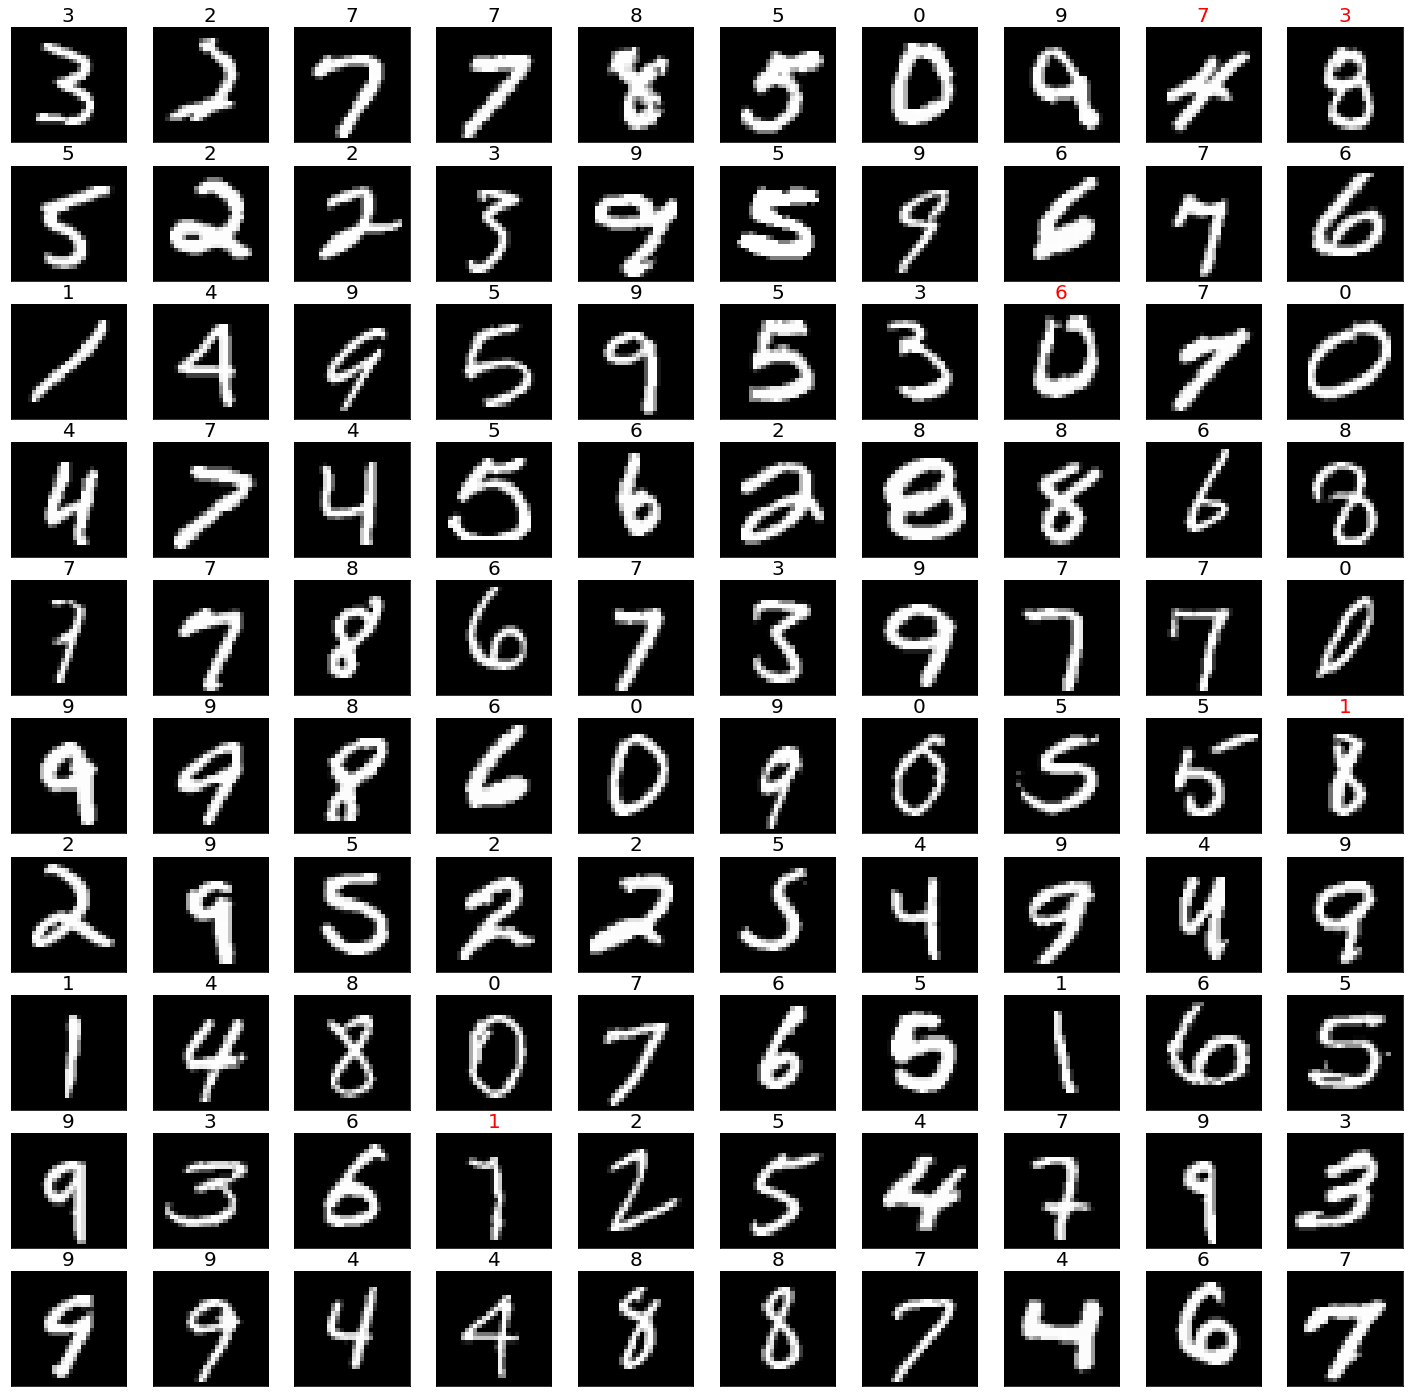

In [238]:
plt.figure(figsize=(25,25))
plt.suptitle('Test Set Predictions')
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(test_data_flat[i], cmap='gray')
    color = "black" if (test_pred_flat[i] == test_true_vals_flat[i]) else "red"
    plt.title(int(test_pred_flat[i]), color=color, size = 20)
    plt.xticks([])
    plt.yticks([])